In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [4]:
from datetime import datetime

df = pd.read_csv('../data/btcusdt.csv', index_col=False)
df['Opentime'] = pd.to_datetime(df['Opentime'])

# cropped out datetime from 2021/12/15 to 2021/12/16
df = df[~(df['Opentime'] < '2021-12-15 00:00:00')]
del df['Ignore']    # remove unused ignored column

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442 entries, 558 to 1999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Opentime            1442 non-null   datetime64[ns]
 1   Open                1442 non-null   float64       
 2   High                1442 non-null   float64       
 3   Low                 1442 non-null   float64       
 4   Close               1442 non-null   float64       
 5   Volume              1442 non-null   float64       
 6   Closetime           1442 non-null   int64         
 7   Quote asset volume  1442 non-null   float64       
 8   Number of trades    1442 non-null   int64         
 9   Taker by base       1442 non-null   float64       
 10  Taker buy quote     1442 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 135.2 KB


In [5]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Candlestick(
        x=df['Opentime'],
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close']
    )]
)
fig.show()

We hence compute the log returns on the closing price of the candlestick.

In [6]:
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,log_returns
558,2021-12-15 00:00:00,46853.87,46853.87,46789.78,46809.98,27.96198,1639497659999,1.309415e+06,923,11.11676,5.205295e+05,NaN
559,2021-12-15 00:01:00,46809.98,46809.98,46742.05,46783.55,21.89239,1639497719999,1.023852e+06,1004,11.12141,5.201427e+05,-0.000565
560,2021-12-15 00:02:00,46778.53,46784.00,46637.01,46720.20,46.92214,1639497779999,2.191078e+06,1625,23.00774,1.074376e+06,-0.001355
561,2021-12-15 00:03:00,46711.49,46720.20,46640.46,46694.39,22.19630,1639497839999,1.036201e+06,921,9.28233,4.332936e+05,-0.000553
562,2021-12-15 00:04:00,46694.39,46799.96,46667.29,46787.11,41.43478,1639497899999,1.936243e+06,1070,19.30262,9.019705e+05,0.001984


In [7]:
minutes2shift = [1, 2, 5, 10, 15, 30, 60, 120, 240]

def generate_lags(data):
    global cols
    cols = []
    for lag in minutes2shift:
        if 'log_returns' in data:
            col = 'lag_{}'.format(lag)
            data[col] = data['log_returns'].shift(lag)
            cols.append(col)
    print(cols)

In [8]:
generate_lags(df)

['lag_1', 'lag_2', 'lag_5', 'lag_10', 'lag_15', 'lag_30', 'lag_60', 'lag_120', 'lag_240']


In [9]:
df.dropna(inplace=True)
corr = pd.DataFrame(df[cols].apply(lambda x: x.corr(df['log_returns'])))
corr

,0
lag_1,0.046646
lag_2,0.004355
lag_5,0.012781
lag_10,0.004380
lag_15,-0.011526
lag_30,0.049333
lag_60,-0.003552
lag_120,0.017863
lag_240,-0.028274


In [10]:
pd.DataFrame(df, columns=['log_returns'].append(cols))

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,...,log_returns,lag_1,lag_2,lag_5,lag_10,lag_15,lag_30,lag_60,lag_120,lag_240
799,2021-12-15 04:01:00,46930.28,46949.99,46897.30,46910.30,12.84874,1639512119999,6.029706e+05,652,6.09884,...,-0.000426,0.001512,0.000747,0.000976,-0.000896,-0.000511,0.000830,0.000024,-0.000805,-0.000565
800,2021-12-15 04:02:00,46910.30,47116.64,46887.35,47082.82,92.31128,1639512179999,4.342208e+06,2164,66.18367,...,0.003671,-0.000426,0.001512,-0.000858,-0.000426,-0.000683,-0.000021,0.001678,0.000156,-0.001355
801,2021-12-15 04:03:00,47082.82,47138.00,47071.48,47131.98,31.12741,1639512239999,1.466361e+06,980,17.81984,...,0.001044,0.003671,-0.000426,-0.001333,0.000582,-0.001382,-0.000385,0.000540,0.001358,-0.000553
802,2021-12-15 04:04:00,47131.99,47131.99,47081.59,47081.59,17.95714,1639512299999,8.458929e+05,655,6.97476,...,-0.001070,0.001044,0.003671,0.000747,0.001556,-0.000098,-0.000296,0.000500,0.000687,0.001984
803,2021-12-15 04:05:00,47082.01,47134.59,47067.36,47120.65,14.58993,1639512359999,6.871150e+05,707,8.73155,...,0.000829,-0.001070,0.001044,0.001512,0.000737,-0.000039,-0.001373,-0.000310,0.001249,0.002187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2021-12-15 23:56:00,46749.99,46824.05,46712.96,46787.91,33.78551,1639583819999,1.579706e+06,950,17.27040,...,0.000811,0.000083,-0.000829,0.000459,0.000797,-0.000375,0.000971,-0.000764,-0.000964,0.000036
1996,2021-12-15 23:57:00,46787.91,46798.47,46670.00,46699.27,53.22740,1639583879999,2.487796e+06,1405,23.46664,...,-0.001896,0.000811,0.000083,0.002532,-0.000836,-0.001220,-0.003015,0.001682,-0.000852,0.000075
1997,2021-12-15 23:58:00,46699.28,46732.27,46613.00,46663.52,98.96265,1639583939999,4.618220e+06,2147,37.48189,...,-0.000766,-0.001896,0.000811,-0.003198,-0.001187,-0.001429,0.001115,0.000656,0.000605,-0.000681
1998,2021-12-15 23:59:00,46663.51,46678.11,46587.00,46632.31,108.82328,1639583999999,5.072973e+06,2101,31.64731,...,-0.000669,-0.000766,-0.001896,-0.000829,-0.001065,-0.000909,-0.000063,0.000060,0.000856,0.000130


<AxesSubplot:xlabel='lag_1', ylabel='lag_2'>

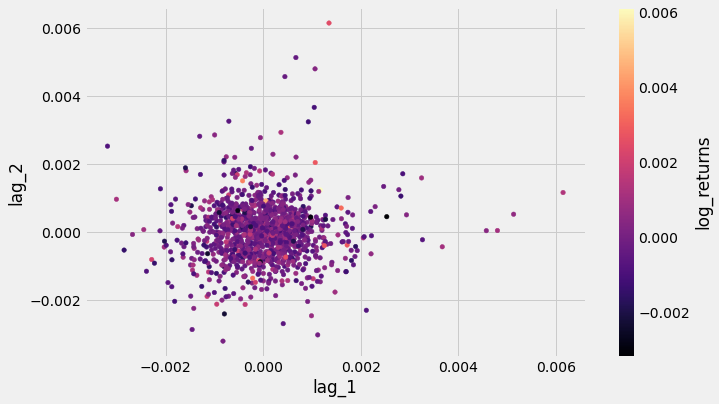

In [11]:
df.plot.scatter(x='lag_1', y='lag_2', c='log_returns',
    cmap='magma', figsize=(10,6), colorbar=True)

In [12]:
df['direction'] = np.sign(df['log_returns']).astype(int)
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,...,lag_1,lag_2,lag_5,lag_10,lag_15,lag_30,lag_60,lag_120,lag_240,direction
799,2021-12-15 04:01:00,46930.28,46949.99,46897.30,46910.30,12.84874,1639512119999,6.029706e+05,652,6.09884,...,0.001512,0.000747,0.000976,-0.000896,-0.000511,0.000830,0.000024,-0.000805,-0.000565,-1
800,2021-12-15 04:02:00,46910.30,47116.64,46887.35,47082.82,92.31128,1639512179999,4.342208e+06,2164,66.18367,...,-0.000426,0.001512,-0.000858,-0.000426,-0.000683,-0.000021,0.001678,0.000156,-0.001355,1
801,2021-12-15 04:03:00,47082.82,47138.00,47071.48,47131.98,31.12741,1639512239999,1.466361e+06,980,17.81984,...,0.003671,-0.000426,-0.001333,0.000582,-0.001382,-0.000385,0.000540,0.001358,-0.000553,1
802,2021-12-15 04:04:00,47131.99,47131.99,47081.59,47081.59,17.95714,1639512299999,8.458929e+05,655,6.97476,...,0.001044,0.003671,0.000747,0.001556,-0.000098,-0.000296,0.000500,0.000687,0.001984,-1
803,2021-12-15 04:05:00,47082.01,47134.59,47067.36,47120.65,14.58993,1639512359999,6.871150e+05,707,8.73155,...,-0.001070,0.001044,0.001512,0.000737,-0.000039,-0.001373,-0.000310,0.001249,0.002187,1


In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [14]:
df['pos_ols_1'] = model.fit(df[cols],
                    df['log_returns']).predict(df[cols])

In [15]:
df['pos_ols_2'] = model.fit(df[cols],
                    df['direction']).predict(df[cols])

In [16]:
df[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
799,0.000126,-0.011009
800,-0.000006,-0.025253
801,0.000189,0.088717
802,0.000004,-0.096914
803,-0.000136,-0.116656


In [17]:
import plotly.express as px

fig = px.scatter_3d(df, x='lag_1', y='lag_2', z='log_returns', color='Close', symbol='direction')
fig.show()

The real value predictions are then transformed to directional values, either -1 or +1.

In [18]:
df[['pos_ols_1', 'pos_ols_2']] = np.where(df[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [19]:
df['pos_ols_1'].value_counts()

-1    643
 1    558
Name: pos_ols_1, dtype: int64

In [20]:
df['pos_ols_2'].value_counts()

-1    672
 1    529
Name: pos_ols_2, dtype: int64

In [21]:
df['strat_ols_1'] = df['pos_ols_1'] * df['log_returns']
df['strat_ols_2'] = df['pos_ols_2'] * df['log_returns']

Now we can plot out the performance of BTC-USD and regression-based strategies over time.

<AxesSubplot:>

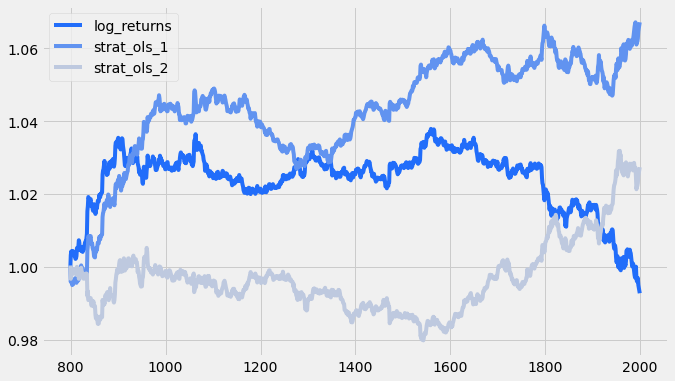

In [22]:
color_dict = {
    'log_returns': '#216DFA',
    'strat_ols_1': '#6193F0',
    'strat_ols_2': '#BEC9DF'
}
column_name = ['log_returns', 'strat_ols_1', 'strat_ols_2']

df[column_name].cumsum().apply(np.exp).plot(color=[color_dict.get(x) for x in column_name], figsize=(10,6))

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [24]:
svm_model = SVC(C=2, kernel='linear', gamma='auto')

In [25]:
split = int(len(df) * 4 / 5)
split

960

In [26]:
train = df.iloc[:split].copy()
train

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,...,lag_15,lag_30,lag_60,lag_120,lag_240,direction,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2
799,2021-12-15 04:01:00,46930.28,46949.99,46897.30,46910.30,12.84874,1639512119999,6.029706e+05,652,6.09884,...,-0.000511,0.000830,0.000024,-0.000805,-0.000565,-1,1,-1,-0.000426,0.000426
800,2021-12-15 04:02:00,46910.30,47116.64,46887.35,47082.82,92.31128,1639512179999,4.342208e+06,2164,66.18367,...,-0.000683,-0.000021,0.001678,0.000156,-0.001355,1,-1,-1,-0.003671,-0.003671
801,2021-12-15 04:03:00,47082.82,47138.00,47071.48,47131.98,31.12741,1639512239999,1.466361e+06,980,17.81984,...,-0.001382,-0.000385,0.000540,0.001358,-0.000553,1,1,1,0.001044,0.001044
802,2021-12-15 04:04:00,47131.99,47131.99,47081.59,47081.59,17.95714,1639512299999,8.458929e+05,655,6.97476,...,-0.000098,-0.000296,0.000500,0.000687,0.001984,-1,1,-1,-0.001070,0.001070
803,2021-12-15 04:05:00,47082.01,47134.59,47067.36,47120.65,14.58993,1639512359999,6.871150e+05,707,8.73155,...,-0.000039,-0.001373,-0.000310,0.001249,0.002187,1,-1,-1,-0.000829,-0.000829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,2021-12-15 19:55:00,48164.97,48176.75,48140.96,48153.69,11.30406,1639569359999,5.443966e+05,495,5.84254,...,-0.000095,-0.001287,0.000426,-0.000444,0.000917,-1,-1,1,0.000234,-0.000234
1755,2021-12-15 19:56:00,48154.75,48165.28,48146.05,48155.43,9.51055,1639569419999,4.579765e+05,423,5.26608,...,0.000193,0.001188,-0.000586,-0.000148,-0.000724,1,1,1,0.000036,0.000036
1756,2021-12-15 19:57:00,48155.44,48165.04,48137.49,48159.03,18.41525,1639569479999,8.867561e+05,647,8.44427,...,0.001235,-0.000644,-0.000147,-0.000232,-0.000169,1,-1,1,-0.000075,0.000075
1757,2021-12-15 19:58:00,48159.03,48159.03,48120.15,48126.26,12.11083,1639569539999,5.830220e+05,622,6.22674,...,-0.000508,-0.000336,-0.000738,0.000856,-0.000240,-1,-1,-1,0.000681,0.000681


In [27]:
svm_model.fit(train[cols], train['direction'])

SVC(C=2, gamma='auto', kernel='linear')

In [28]:
accuracy_score(train['direction'], svm_model.predict(train[cols]))

0.5114583333333333

<AxesSubplot:>

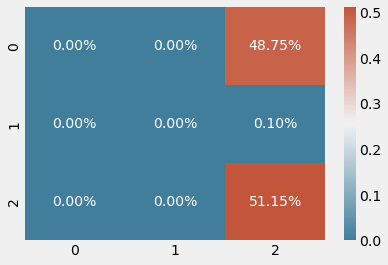

In [29]:
train_cfmatrix = confusion_matrix(train['direction'], svm_model.predict(train[cols]))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(train_cfmatrix / np.sum(train_cfmatrix), annot=True, fmt='.2%', cmap=cmap)

In [30]:
test = df.iloc[split:].copy()
test['position'] = svm_model.predict(test[cols])

In [31]:
accuracy_score(test['direction'], test['position'])

0.43568464730290457

<AxesSubplot:>

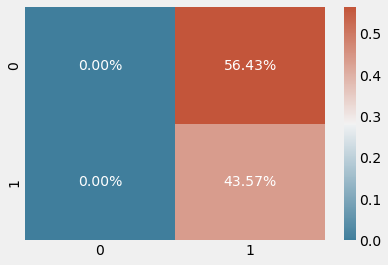

In [32]:
test_cfmatrix = confusion_matrix(test['direction'], test['position'])
sns.heatmap(test_cfmatrix / np.sum(test_cfmatrix), annot=True, fmt='.2%', cmap=cmap)

In [98]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data: pd.DataFrame, period: int):
    rolling_mean = data.rolling(period).mean()
    rolling_std = data.rolling(period).std()

    # Plot rolling statistics
    fig = plt.figure(figsize=(10,6))
    original = plt.plot(data, color='#d0cbc9', label='Original', alpha=0.5)
    mean = plt.plot(rolling_mean, color='#f84c1e', label='Rolling mean', alpha=0.6, linewidth=2.85)
    std_dev = plt.plot(rolling_std, color='#595d66', label='Rolling std', linewidth=2.85)
    plt.legend(loc='best')
    plt.title('Rolling mean & std deviation')
    plt.show()

    # use Akaike Information Criterion
    test = adfuller(data, autolag='AIC')
    print('Augmented Dickey-Fuller test summary:')
    output = pd.Series(test[:4], index=[
                'Test statistic',
                'p-value',
                'Num of lags used',
                'Num of observations'])
    
    for key, value in test[4].items():
        output[f'Critical value ({key})'] = value
    print(output)

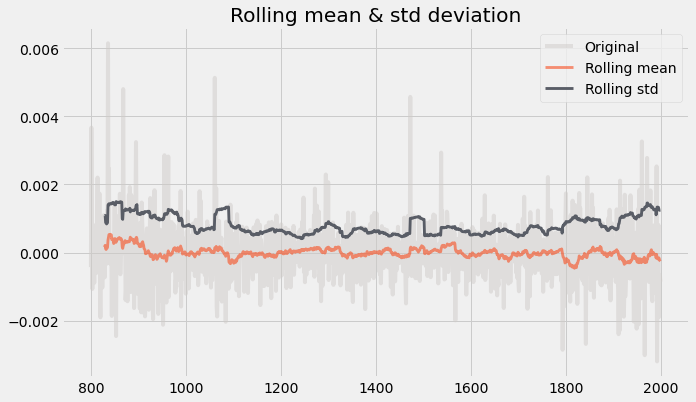

Augmented Dickey-Fuller test summary:
Test statistic           -32.996517
p-value                    0.000000
Num of lags used           0.000000
Num of observations     1200.000000
Critical value (1%)       -3.435811
Critical value (5%)       -2.863952
Critical value (10%)      -2.568054
dtype: float64


In [101]:
a = test_stationarity(df['log_returns'], 30)
a

## References

- [Huiwen., Wenyang., Shanshan.(2021, March 31), Forecasting open-high-low-close data contained in candlestick chart](https://arxiv.org/pdf/2104.00581.pdf)
- [Gerald. M, (2019, April 25). Advanced candlesticks for machine learning(i): tick bars](https://towardsdatascience.com/advanced-candlesticks-for-machine-learning-i-tick-bars-a8b93728b4c5)